In [1]:
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from time import time

from tensorflow.keras.datasets import cifar10

In [2]:
def id_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    X_shortcut = X
   
    X = Conv2D(filters=filters, kernel_size=(1, 1), strides=(1, 1), padding='same', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)


    X = Conv2D(filters=filters, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

In [3]:
def conv_block(X, f, filters, stage, block, s=2):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    X_shortcut = X
    
    X = Conv2D(filters=filters, kernel_size=(1, 1), strides=(s, s), padding='same', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(filters=filters, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    
    X_shortcut = Conv2D(filters=filters, kernel_size=(1, 1), strides=(s, s), padding='same', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [4]:
def ResNet18(input_shape=(28, 28, 1)):

    # Input 
    X_input = Input(input_shape)
    
    #X = ZeroPadding2D((3, 3))(X_input)

    # Conv1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0), padding="same")(X_input)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2), padding="same")(X)

    # Layer 1
    X = id_block(X, 3, 64, stage=2, block='a')
    X = id_block(X, 3, 64, stage=2, block='b')

    # Layer 2
    X = conv_block(X, f=3, filters=128, stage=3, block='a', s=2)
    X = id_block(X, 3, 128, stage=3, block='b')

    # Layer 3
    X = conv_block(X, f=3, filters=256, stage=4, block='a', s=2)
    X = id_block(X, 3, 256, stage=4, block='b')

    # Layer 4
    X = conv_block(X, f=3, filters=512, stage=5, block='a', s=2)
    X = id_block(X, 3, 512, stage=5, block='b')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    
    model = Model(inputs=X_input, outputs=X, name='ResNet18')

    return model

In [5]:
(train_x, train_y), (test_x, test_y) = cifar10.load_data()

# normalize to range 0-1
train_x = train_x / 255.0
test_x = test_x / 255.0

val_x = train_x[:5000]
val_y = train_y[:5000]

In [6]:
Input18 = ResNet18(train_x[0].shape)

In [7]:
headModel18 = Input18.output
# Flatten
headModel18 = Flatten()(headModel18)
# FC
headModel18 = Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(headModel18)
headModel18 = Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(headModel18)
# Output
headModel18 = Dense(10,activation='softmax', name='fc3',kernel_initializer=glorot_uniform(seed=0))(headModel18)

In [8]:
model18 = Model(inputs=Input18.input, outputs=headModel18)

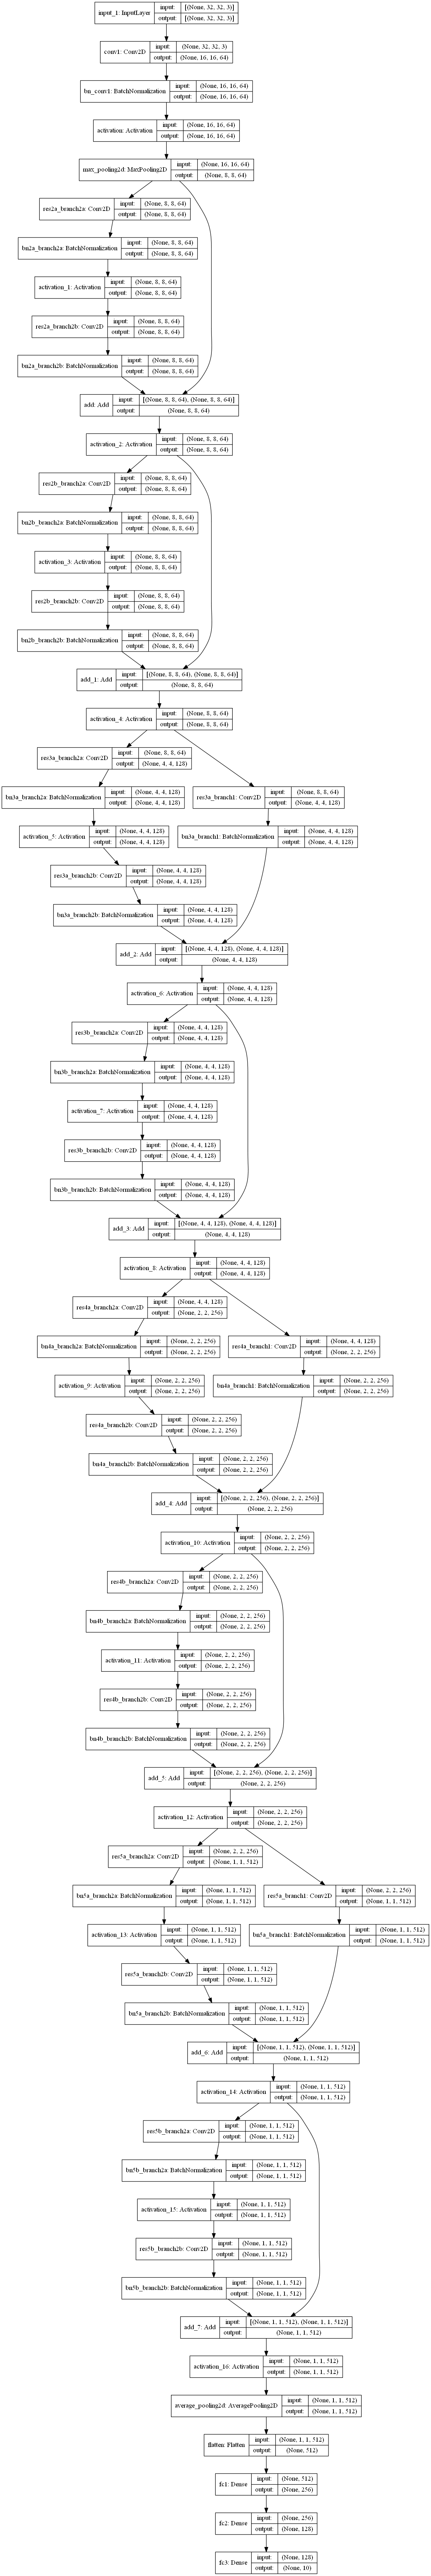

In [9]:
plot_model(model18, show_shapes=True)

In [10]:
model18.compile(optimizer='adam', loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
#model18.summary()
len(model18.layers)

72

In [11]:
es = tf.keras.callbacks.EarlyStopping(monitor='loss', verbose=1)
list_cb = [es]

In [13]:
start = time()
model18.fit( train_x , train_y , epochs=50, batch_size=1024, validation_split=0.3, callbacks=list_cb)
training_time = time()-start

Epoch 1/50
35/35 [==============================] - 542s 16s/step - loss: 1.4834 - accuracy: 0.4614 - val_loss: 2.2918 - val_accuracy: 0.1282
Epoch 2/50
35/35 [==============================] - 544s 16s/step - loss: 1.2058 - accuracy: 0.5680 - val_loss: 2.4493 - val_accuracy: 0.1051
Epoch 3/50
35/35 [==============================] - 531s 15s/step - loss: 1.0343 - accuracy: 0.6275 - val_loss: 2.5810 - val_accuracy: 0.1269
Epoch 4/50
35/35 [==============================] - 541s 15s/step - loss: 0.8888 - accuracy: 0.6831 - val_loss: 2.6099 - val_accuracy: 0.1937
Epoch 5/50
35/35 [==============================] - 536s 15s/step - loss: 0.7696 - accuracy: 0.7243 - val_loss: 2.7678 - val_accuracy: 0.1715
Epoch 6/50
35/35 [==============================] - 533s 15s/step - loss: 0.6472 - accuracy: 0.7687 - val_loss: 3.3290 - val_accuracy: 0.2238
Epoch 7/50
35/35 [==============================] - 550s 16s/step - loss: 0.5323 - accuracy: 0.8122 - val_loss: 3.0752 - val_accuracy: 0.2219
Epoch 

In [14]:
model18.evaluate(test_x, test_y)

313/313 [==============================] - 5s 17ms/step - loss: 2.3392 - accuracy: 0.5795


[2.3391895294189453, 0.5795000195503235]

In [15]:
model18.evaluate(train_x, train_y)

1563/1563 [==============================] - 32s 21ms/step - loss: 1.2282 - accuracy: 0.7314


[1.228227138519287, 0.7313600182533264]

In [16]:
training_time

8491.495813846588